# Assignment 4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import solvers
import math
from cvxopt import matrix
import time

## Question 5.1

In [2]:
train_data = np.loadtxt("train_data.txt")
test_data = np.loadtxt("test_data.txt")

train_label = np.loadtxt("train_label.txt").reshape(-1,1)
test_label = np.loadtxt("test_label.txt").reshape(-1, 1)

### 5.1.a

In [3]:
means = train_data.mean(axis = 0)

train_data = train_data - means
test_data = test_data - means

print("The means of the 3rd and 10th columns are {0} and {1} respectively".format(means[2], means[9]))

The means of the 3rd and 10th columns are 2.54 and 2.527 respectively


### 5.1.b

In [4]:
stdevs = train_data.std(axis = 0)

train_data = train_data/stdevs
test_data = test_data/stdevs

print("The means of the 3rd and 10th columns are {0} and {1} respectively".format(stdevs[2], stdevs[9]))

The means of the 3rd and 10th columns are 1.0744300814850678 and 1.1239532908444194 respectively


### Comments

The mean and standard deviation was gotten from the training sample so to generalize well on normalization. If the mean and standard deviation were taken from the test data seperately, then the normalization criteria will not be uniform accross data set. Hence, the model will not predict accurately.


## Question 5.2

In [5]:
train_data.shape, train_label.shape

((1000, 60), (1000, 1))

In [6]:
# Implementation of a Support Vector Machine (SVM)

def train_svm(train_data, train_label, C):
    
    """Train linear SVM (primal form)
    Argument:
        train_data: N*D matrix, each row as a sample and each column as a feature
        train_label: N*1 vector, each row as a label
        C: tradeoff parameter (on slack variable side)
    Return:
        w: feature vector (column vector)
        b: bias term
    """

    w_matrix = np.identity(train_data.shape[1])
    w_zeros = np.zeros((train_data.shape[1], train_data.shape[0]+1))
    w_upper = np.concatenate((w_matrix, w_zeros), axis = 1)
    P = np.concatenate((w_upper, np.zeros((train_data.shape[0]+1, w_upper.shape[1]))), axis = 0) #Size of P is (1061, 1061)
    P = matrix(P, tc = 'd')
    
    q_upper = np.zeros((1, (train_data.shape[1]+1)))
    q_zethas = np.zeros((1, (train_data.shape[0]))) + C
    q = np.concatenate((q_upper, q_zethas), axis = 1).T
    q = matrix(q, tc = 'd')
    
    yx = train_data*train_label*-1
    yx_zetha = np.concatenate((yx, train_label*-1), axis = 1)
    G_upper = np.concatenate((yx_zetha, np.identity(train_data.shape[0])*-1), axis = 1)
    G_lower_zeros = np.zeros((yx_zetha.shape))
    G_lower_ones = (np.identity(train_data.shape[0]) *-1).astype(float)
    G_lower = np.concatenate((G_lower_zeros, G_lower_ones), axis = 1)
    G = np.concatenate((G_upper, G_lower), axis = 0)
    G = matrix(G, tc = 'd')
    
    h_upper = np.ones((train_data.shape[0],1))*-1
    h_lower = np.zeros((train_data.shape[0],1))
    h = np.concatenate((h_upper, h_lower), axis = 0)
    h = matrix(h, tc = 'd')
    
    sol = solvers.qp(P, q, G, h)
    
    w = np.array(sol['x'][0:train_data.shape[1]])
    b = sol['x'][train_data.shape[1]]
    
    return w, b
    
    


def test_svm(test_data, test_label, w, b):
    """Test linear SVM
    Argument:
        test_data: M*D matrix, each row as a sample and each column as a feature
        test_label: M*1 vector, each row as a label
        w: feature vector
        b: bias term
    Return:
        test_accuracy: a float between [0, 1] representing the test accuracy
    """
    
    predict = test_data@w + b
    
    sign = np.sign(predict)
    
    accuracy = (sign==test_label).sum()/len(test_label)
    
    return accuracy


## Question 5.3

### 5.3.a

In [7]:
def cross_validation(train_data, folds, C):
    time_taken = []
    accuracy = []
    
    index = int(train_data.shape[0]/folds)
    
    for i in range(0, train_data.shape[0], index):

    
        cv_test_data = train_data[i:i+index, :]
        cv_test_label = train_label[i:i+index, :]
        cv_train_data = np.delete(train_data, tuple(i for i in range(i, i+index)), 0)
        cv_train_label = np.delete(train_label, tuple(i for i in range(i, i+index)), 0)
        start = time.time()
        w, b = train_svm(cv_train_data, cv_train_label, C)
        stop = time.time()

        accuracy_score = test_svm(cv_test_data, cv_test_label, w, b)

        accuracy.append(accuracy_score)
        time_taken.append(stop-start)
    
    final_accuracy = np.array(accuracy).mean()
    final_time = np.array(time_taken).mean()
    
    return final_accuracy, final_time

In [8]:
C = []
for i in range(-6,7):
    C.append(pow(4, i))
accuracy = []
time_used = []

for i in C:
    acc, tim = cross_validation(train_data, 5, i)
    accuracy.append(acc)
    time_used.append(tim)
    

     pcost       dcost       gap    pres   dres
 0:  2.2076e-01  1.9686e+02  6e+03  3e+00  1e+03
 1:  5.9756e-01 -6.3221e+01  6e+01  3e-02  2e+01
 2:  5.3784e-01 -3.2293e+00  4e+00  2e-03  9e-01
 3:  4.3031e-01  1.4229e-01  3e-01  1e-15  5e-16
 4:  2.0110e-01  1.6086e-01  4e-02  7e-16  9e-17
 5:  1.8219e-01  1.7280e-01  9e-03  4e-16  1e-16
 6:  1.8223e-01  1.7288e-01  9e-03  4e-16  1e-16
 7:  1.8121e-01  1.7328e-01  8e-03  3e-16  1e-16
 8:  1.8016e-01  1.7385e-01  6e-03  3e-16  1e-16
 9:  1.7859e-01  1.7474e-01  4e-03  3e-16  3e-16
10:  1.7755e-01  1.7544e-01  2e-03  3e-16  3e-16
11:  1.7679e-01  1.7598e-01  8e-04  3e-16  2e-16
12:  1.7645e-01  1.7624e-01  2e-04  3e-16  3e-16
13:  1.7635e-01  1.7633e-01  2e-05  3e-16  1e-16
14:  1.7634e-01  1.7634e-01  4e-07  3e-16  4e-16
15:  1.7634e-01  1.7634e-01  6e-09  3e-16  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.2505e-01  1.9767e+02  6e+03  3e+00  1e+03
 1:  6.0181e-01 -6.2657e+01  6e+01  3e-02  2e+0

 1:  6.9712e+00 -6.2898e+01  7e+01  3e-02  2e+01
 2:  6.0599e+00 -1.5650e+00  8e+00  2e-03  8e-01
 3:  2.0013e+00  1.3664e+00  6e-01  7e-16  1e-15
 4:  1.7387e+00  1.5804e+00  2e-01  4e-16  8e-16
 5:  1.6829e+00  1.6393e+00  4e-02  3e-16  1e-15
 6:  1.6660e+00  1.6550e+00  1e-02  3e-16  2e-15
 7:  1.6614e+00  1.6593e+00  2e-03  3e-16  6e-15
 8:  1.6605e+00  1.6602e+00  3e-04  3e-16  8e-15
 9:  1.6603e+00  1.6603e+00  2e-05  3e-16  2e-14
10:  1.6603e+00  1.6603e+00  5e-07  3e-16  6e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  9.6194e-01  2.0965e+02  6e+03  3e+00  1e+03
 1:  7.1415e+00 -6.3143e+01  7e+01  3e-02  2e+01
 2:  6.1891e+00 -5.2454e-01  7e+00  1e-03  5e-01
 3:  2.0553e+00  1.4339e+00  6e-01  6e-05  3e-02
 4:  1.8170e+00  1.6659e+00  2e-01  1e-05  6e-03
 5:  1.7676e+00  1.7218e+00  5e-02  3e-06  1e-03
 6:  1.7512e+00  1.7391e+00  1e-02  7e-07  3e-04
 7:  1.7461e+00  1.7445e+00  2e-03  7e-08  3e-05
 8:  1.7454e+00  1.7451e+00  3e-04  1e-08  5e-

 5:  2.0154e+01  1.9028e+01  1e+00  1e-04  3e-02
 6:  1.9737e+01  1.9310e+01  4e-01  3e-05  8e-03
 7:  1.9571e+01  1.9425e+01  1e-01  8e-06  2e-03
 8:  1.9512e+01  1.9467e+01  4e-02  2e-06  5e-04
 9:  1.9493e+01  1.9481e+01  1e-02  1e-07  3e-05
10:  1.9488e+01  1.9485e+01  2e-03  2e-08  5e-06
11:  1.9486e+01  1.9486e+01  9e-05  5e-10  2e-07
12:  1.9486e+01  1.9486e+01  2e-06  1e-11  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1708e+01  6.3455e+02  7e+03  3e+00  2e+02
 1:  3.5326e+02 -3.8446e+02  8e+02  3e-01  2e+01
 2:  1.9695e+02  7.0816e+00  2e+02  4e-02  3e+00
 3:  9.4453e+01  5.8491e+01  4e+01  8e-03  5e-01
 4:  8.0806e+01  6.7392e+01  1e+01  2e-03  2e-01
 5:  7.5728e+01  7.0506e+01  5e+00  7e-04  5e-02
 6:  7.4074e+01  7.1547e+01  3e+00  3e-04  2e-02
 7:  7.3187e+01  7.2110e+01  1e+00  1e-04  7e-03
 8:  7.2757e+01  7.2384e+01  4e-01  2e-05  2e-03
 9:  7.2607e+01  7.2490e+01  1e-01  7e-06  5e-04
10:  7.2552e+01  7.2529e+01  2e-02  6e-16  9e-

 7:  1.1584e+03  1.1215e+03  4e+01  1e-03  2e-03
 8:  1.1449e+03  1.1307e+03  1e+01  1e-04  3e-04
 9:  1.1394e+03  1.1348e+03  5e+00  4e-05  8e-05
10:  1.1375e+03  1.1362e+03  1e+00  4e-06  1e-05
11:  1.1370e+03  1.1366e+03  4e-01  7e-07  2e-06
12:  1.1368e+03  1.1368e+03  7e-02  4e-08  8e-08
13:  1.1368e+03  1.1368e+03  2e-03  1e-09  3e-09
14:  1.1368e+03  1.1368e+03  2e-05  1e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.8472e+03  1.3082e+04  5e+04  1e+01  2e+01
 1:  5.0706e+03 -1.3894e+03  1e+04  1e+00  3e+00
 2:  1.8843e+03  6.7911e+02  2e+03  2e-01  4e-01
 3:  1.3784e+03  9.7866e+02  5e+02  5e-02  1e-01
 4:  1.3190e+03  1.0544e+03  3e+02  2e-02  5e-02
 5:  1.2555e+03  1.1032e+03  2e+02  9e-03  2e-02
 6:  1.2052e+03  1.1377e+03  7e+01  2e-03  6e-03
 7:  1.1841e+03  1.1528e+03  3e+01  8e-04  2e-03
 8:  1.1731e+03  1.1600e+03  1e+01  2e-04  4e-04
 9:  1.1682e+03  1.1635e+03  5e+00  3e-05  7e-05
10:  1.1669e+03  1.1645e+03  2e+00  1e-05  3e-

13:  4.6320e+03  4.6305e+03  1e+00  1e-06  6e-07
14:  4.6315e+03  4.6310e+03  5e-01  4e-07  2e-07
15:  4.6313e+03  4.6311e+03  2e-01  1e-07  5e-08
16:  4.6312e+03  4.6312e+03  1e-02  9e-09  4e-09
17:  4.6312e+03  4.6312e+03  3e-03  1e-09  5e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.4582e+06  1.7261e+06  6e+06  1e+02  1e+01
 1:  3.7000e+05 -1.6766e+05  1e+06  1e+01  1e+00
 2:  1.0140e+05  4.2737e+03  2e+05  1e+00  1e-01
 3:  2.8345e+04  1.1881e+04  3e+04  2e-01  2e-02
 4:  2.4876e+04  1.4245e+04  1e+04  1e-01  1e-02
 5:  2.2254e+04  1.5615e+04  9e+03  6e-02  6e-03
 6:  2.0633e+04  1.6529e+04  5e+03  3e-02  3e-03
 7:  1.9803e+04  1.7092e+04  3e+03  2e-02  2e-03
 8:  1.9176e+04  1.7503e+04  2e+03  8e-03  8e-04
 9:  1.8817e+04  1.7748e+04  1e+03  2e-03  2e-04
10:  1.8493e+04  1.7947e+04  6e+02  7e-04  7e-05
11:  1.8271e+04  1.8085e+04  2e+02  1e-04  1e-05
12:  1.8197e+04  1.8138e+04  6e+01  3e-05  3e-06
13:  1.8175e+04  1.8154e+04  2e+01  1e-05  1e-

 1:  6.3476e+06 -2.3087e+06  2e+07  5e+01  1e+00
 2:  1.1133e+06  7.5887e+03  2e+06  3e+00  7e-02
 3:  1.3941e+05  4.7692e+04  1e+05  2e-01  6e-03
 4:  1.2240e+05  5.6192e+04  8e+04  1e-01  3e-03
 5:  1.0362e+05  6.2541e+04  5e+04  7e-02  2e-03
 6:  9.5490e+04  6.7770e+04  3e+04  3e-02  6e-04
 7:  8.8278e+04  7.1075e+04  2e+04  1e-02  3e-04
 8:  8.3323e+04  7.3337e+04  1e+04  5e-03  1e-04
 9:  7.9936e+04  7.5025e+04  5e+03  2e-03  4e-05
10:  7.8283e+04  7.5886e+04  2e+03  6e-04  1e-05
11:  7.7478e+04  7.6362e+04  1e+03  2e-04  5e-06
12:  7.7062e+04  7.6622e+04  4e+02  5e-05  1e-06
13:  7.6930e+04  7.6714e+04  2e+02  2e-05  6e-07
14:  7.6864e+04  7.6757e+04  1e+02  8e-06  2e-07
15:  7.6817e+04  7.6792e+04  3e+01  1e-06  3e-08
16:  7.6805e+04  7.6801e+04  4e+00  7e-08  2e-09
17:  7.6803e+04  7.6803e+04  7e-01  1e-08  3e-10
18:  7.6803e+04  7.6803e+04  1e-01  2e-09  4e-11
19:  7.6803e+04  7.6803e+04  2e-03  2e-11  7e-13
Optimal solution found.
     pcost       dcost       gap    pres   dr

 6:  1.7102e+06  9.6290e+05  9e+05  6e-02  1e-04
 7:  1.5163e+06  1.0346e+06  6e+05  3e-02  5e-05
 8:  1.4300e+06  1.0726e+06  4e+05  2e-02  3e-05
 9:  1.3372e+06  1.1142e+06  2e+05  9e-03  1e-05
10:  1.2759e+06  1.1454e+06  1e+05  4e-03  7e-06
11:  1.2327e+06  1.1674e+06  7e+04  2e-03  3e-06
12:  1.2092e+06  1.1813e+06  3e+04  6e-04  9e-07
13:  1.1981e+06  1.1875e+06  1e+04  9e-05  1e-07
14:  1.1948e+06  1.1899e+06  5e+03  3e-05  6e-08
15:  1.1932e+06  1.1909e+06  2e+03  8e-06  1e-08
16:  1.1922e+06  1.1917e+06  6e+02  4e-07  7e-10
17:  1.1920e+06  1.1919e+06  9e+01  6e-08  9e-11
18:  1.1919e+06  1.1919e+06  2e+01  1e-08  2e-11
19:  1.1919e+06  1.1919e+06  4e-01  1e-10  6e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0212e+10  6.9107e+09  2e+10  9e+03  1e+01
 1:  1.4716e+09 -6.9937e+08  4e+09  9e+02  1e+00
 2:  3.6474e+08 -2.9254e+07  6e+08  9e+01  2e-01
 3:  1.0801e+07  6.6117e+05  1e+07  1e+00  2e-03
 4:  2.0703e+06  7.1996e+05  2e+06  2e-01  3e-

In [9]:
new_C = []

for i in range(-6,7):
    new_C.append(str(4) + "^" + str(i))

In [10]:
table = pd.DataFrame(list(zip(new_C, accuracy, time_used)), columns = ["C", "Accuracy", "Time"])
table

,C,Accuracy,Time
0,4^-6,0.517,1.226086
1,4^-5,0.784,0.661514
2,4^-4,0.807,0.670318
3,4^-3,0.809,0.749826
4,4^-2,0.802,0.826950
5,4^-1,0.800,0.786748
6,4^0,0.796,0.886035
7,4^1,0.798,0.968956
8,4^2,0.800,1.050318
9,4^3,0.800,1.125260


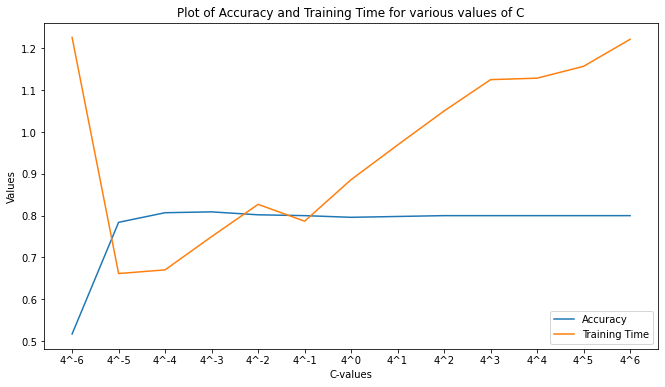

In [11]:
fig, ax = plt.subplots(figsize = (11, 6))
plt.plot(table["Accuracy"], label = "Accuracy")
plt.plot(table["Time"], label = "Training Time")
plt.xticks([i for i in range(0,13)])
ax.set_xticklabels(table["C"])
plt.ylabel("Values")
plt.xlabel("C-values")
plt.title("Plot of Accuracy and Training Time for various values of C")
plt.legend()
plt.show()


### Comments

As C increases, the cross validation accuracy increases and peaks at a point where C = 4^-3 and then begins to drop briefly to when C was zero and then continues to increase but does not get to the accuracy when C was equal to 4^-3. On the other hand, as C increases, the average training time generally reduces and thereafter continues to increase as seen in the plot above


### 5.3.b

Based on the average cross validation accuracy, C = 4^-3 is chosen since it had the highest accuracy score of 0.809

### 5.3.c

In [12]:
c = pow(4, -3)
w, b = train_svm(train_data, train_label, c)

     pcost       dcost       gap    pres   dres
 0:  3.9085e+00  2.8531e+02  8e+03  3e+00  2e+03
 1:  3.4417e+01 -1.1354e+02  2e+02  5e-02  3e+01
 2:  2.4353e+01 -4.8414e+00  3e+01  5e-03  3e+00
 3:  8.2807e+00  5.5603e+00  3e+00  1e-04  8e-02
 4:  7.5191e+00  6.2258e+00  1e+00  5e-05  3e-02
 5:  7.1081e+00  6.5414e+00  6e-01  2e-05  1e-02
 6:  6.9353e+00  6.6832e+00  3e-01  6e-06  4e-03
 7:  6.8462e+00  6.7550e+00  9e-02  8e-07  5e-04
 8:  6.8120e+00  6.7815e+00  3e-02  2e-07  1e-04
 9:  6.7972e+00  6.7938e+00  3e-03  3e-09  2e-06
10:  6.7955e+00  6.7952e+00  3e-04  2e-10  1e-07
11:  6.7953e+00  6.7953e+00  5e-06  3e-12  2e-09
Optimal solution found.


In [13]:
accuracy = test_svm(test_data, test_label, w, b)
accuracy

0.8464367816091954